In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as F
import warnings
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
warnings.filterwarnings('ignore')

In [2]:
Path = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

In [3]:
class SegmentDataset(Dataset):
    def __init__(self, root_dir, img_transform=None, mask_transform=None):
        self.pairs = []
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        for class_name in sorted(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path) or class_name.endswith(('.txt', '.m')):
                continue

            img_dir = os.path.join(class_path, class_name)
            mask_dir = os.path.join(class_path, f'{class_name} GT')
            if not (os.path.exists(img_dir) and os.path.exists(mask_dir)):
                continue

            img_files = {f for f in os.listdir(img_dir) if f.lower().endswith('.png')}
            mask_files = {f for f in os.listdir(mask_dir) if f.lower().endswith('.png')}
            for f in sorted(img_files & mask_files):
                self.pairs.append((os.path.join(img_dir, f), os.path.join(mask_dir, f)))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, img_path

In [4]:
img_size = 224  

img_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

dataset = SegmentDataset(root_dir=Path, 
                         img_transform=img_transform, 
                         mask_transform=mask_transform)

In [5]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Отменяет нормализацию изображения"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)


Длина датасета: 9000
Пример 1: 00001.png
Пример 2: 00002.png
Пример 3: 00003.png


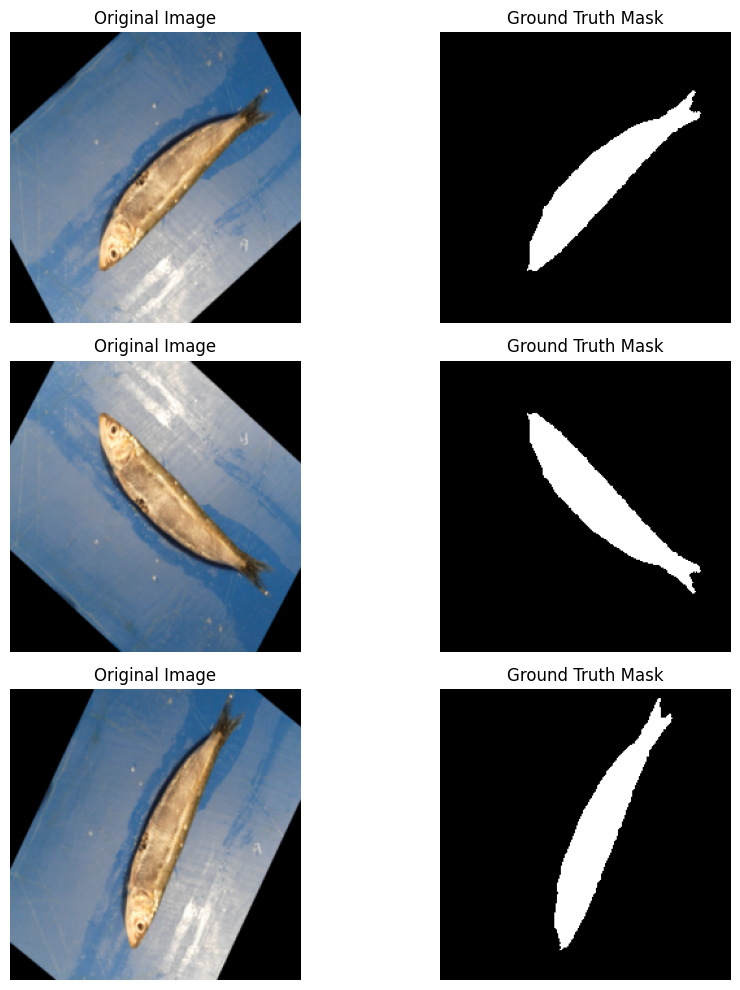

In [6]:
dataset = SegmentDataset(Path, img_transform, mask_transform)
print(f'\nДлина датасета: {len(dataset)}')

fig, axes = plt.subplots(3,2, figsize=(10,10))
axes = axes.flatten()

for i in range(3):
    img, mask, path = dataset[i]
    img_show = denormalize(img).detach().cpu().permute(1, 2, 0).numpy() 

    
    mask_show = mask.squeeze().numpy()

    axes[2*i].imshow(img_show)
    axes[2*i].set_title("Original Image")
    axes[2*i].axis("off")

    axes[2*i+1].imshow(mask_show, cmap='gray')
    axes[2*i+1].set_title("Ground Truth Mask")
    axes[2*i+1].axis("off")

    print(f'Пример {i+1}: {os.path.basename(path)}')

plt.tight_layout()
plt.show()

In [7]:
total = len(dataset)
train_size = int(0.7 * total)
val_test_size = total - train_size

train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])

val_size = int(0.6 * len(val_test_dataset))  
test_size = len(val_test_dataset) - val_size  

val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)


print(f"Train: {len(train_dataset)}")
print(f"Val:   {len(val_dataset)}")
print(f"Test:  {len(test_dataset)}")

Train: 6300
Val:   1620
Test:  1080


## Модель U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход изображение c рыбой, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

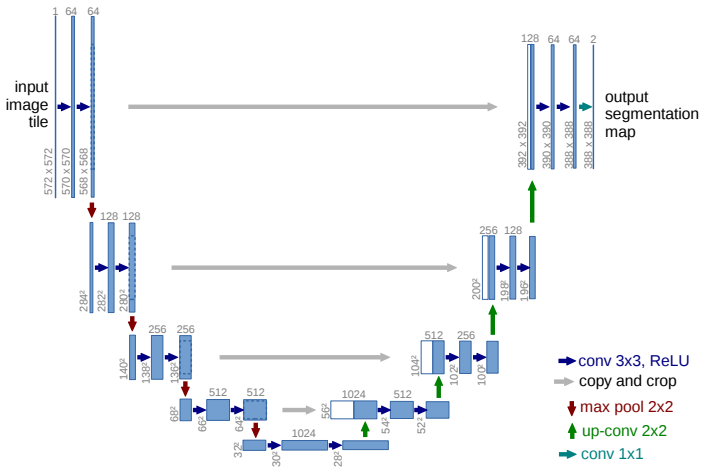

In [8]:
class EncoderUNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels,depth=3, kernel_size=3, padding=1):
        super(EncoderUNetBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
        self.layers.append(nn.ReLU(inplace=True))
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding))
            self.layers.append(nn.ReLU(inplace=True))
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        skip_connection = x
        x = self.maxpool(x)
        return x, skip_connection

In [9]:
class DecoderUNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth=3, kernel_size=3, padding=1):
        super(DecoderUNetBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.upsampling = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
        self.layers.append(nn.ReLU(inplace=True))

        for i in range(depth-1):
            self.layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding))
            self.layers.append(nn.ReLU(inplace=True))

    def forward(self, x, skip_connection):
        x = self.upsampling(x)
        
        diffY = skip_connection.size()[2] - x.size()[2]
        diffX = skip_connection.size()[3] - x.size()[3]

        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])

        x = torch.cat([x, skip_connection], dim=1)
        for layer in self.layers:
            x = layer(x)

        return x
        

In [10]:
class UNet(nn.Module):
  def __init__(self, in_channels=3, n_class=1, num_features=64):
    super(UNet, self).__init__()

    self.encoder1 = EncoderUNetBlock(in_channels, num_features, depth=3)
    self.encoder2 = EncoderUNetBlock(num_features, num_features*2, depth=3)
    self.encoder3 = EncoderUNetBlock(num_features*2, num_features*4, depth=3)
    self.encoder4 = EncoderUNetBlock(num_features*4, num_features*8, depth=3)

    self.bottleneck = nn.Sequential(nn.Conv2d(num_features*8, num_features*16, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(num_features*16,num_features*16, kernel_size=3, padding=1),
                                  nn.ReLU(inplace=True)
                                  )

    self.decoder4 = DecoderUNetBlock(num_features*16, num_features*8, depth=3)
    self.decoder3 = DecoderUNetBlock(num_features*8, num_features*4, depth=3)
    self.decoder2 = DecoderUNetBlock(num_features*4, num_features*2, depth=3)
    self.decoder1 = DecoderUNetBlock(num_features*2, num_features, depth=3)

    self.final_conv = nn.Conv2d(num_features, n_class, kernel_size=1)

  def forward(self, x):
    x, skip1 = self.encoder1(x)
    x, skip2 = self.encoder2(x)
    x, skip3 = self.encoder3(x)
    x, skip4 = self.encoder4(x)

    x = self.bottleneck(x)

    x = self.decoder4(x, skip4)
    x = self.decoder3(x, skip3)
    x = self.decoder2(x, skip2)
    x = self.decoder1(x, skip1)

    x = self.final_conv(x)

    return x

### IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

In [11]:
def iou_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.3):
    

    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    return tp.item(), fp.item(), fn.item()

### Train, Validation

In [12]:
def fit_one_epoch(model, train_dataloader, optimizer, loss_func, device):
    """Функция для оценки на одной эпохе"""
    model.train()
    epoch_correct_predictions = 0.0
    epoch_all_predictions = 0.0
    train_loss = 0.0
    tp_total = 0.0
    fp_total = 0.0
    fn_total = 0.0
    for X_batch, y_batch,_ in tqdm(train_dataloader, desc='training'):
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outp = model(X_batch)
        loss = loss_func(outp,y_batch)
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(outp)>0.3).float()
        batch_correct_predictions = (preds==y_batch).sum().item()
        batch_all_predictions = preds.numel()

        epoch_correct_predictions+=batch_correct_predictions
        epoch_all_predictions+=batch_all_predictions
        tp, fp, fn = iou_score(outp, y_batch)
        tp_total += tp
        fp_total += fp
        fn_total += fn
        train_loss+=loss.item()

    train_accuracy=epoch_correct_predictions/epoch_all_predictions
    eps = 1e-8
    train_iou = (tp_total + eps) / (tp_total + fp_total + fn_total + eps)
    train_loss = train_loss/len(train_dataloader)

    return train_accuracy, train_iou, train_loss

        

In [13]:
def evaluate(model, val_dataloader, loss_func, device):
    """Функция для оценки на валидационной выборке"""
    model.eval()
    val_correct_predictions = 0.0
    val_all_predictions = 0.0
    val_loss = 0.0
    tp_total = 0.0
    fp_total = 0.0
    fn_total = 0.0

    with torch.no_grad():
        for X_batch, y_batch,_ in tqdm(val_dataloader, desc="Validation"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outp = model(X_batch)
            loss = loss_func(outp, y_batch)

            
            preds = (torch.sigmoid(outp) > 0.3).float()
            batch_correct_predictions = (preds == y_batch).sum().item()
            batch_all_predictions = y_batch.numel()

            val_correct_predictions += batch_correct_predictions
            val_all_predictions += batch_all_predictions
            tp, fp, fn = iou_score(outp, y_batch)
            tp_total += tp
            fp_total += fp
            fn_total += fn
            val_loss += loss.item()

    val_accuracy = val_correct_predictions / val_all_predictions
    eps = 1e-8
    val_iou = (tp_total + eps) / (tp_total + fp_total + fn_total + eps)
    val_loss = val_loss / len(val_dataloader)
    return val_accuracy, val_iou, val_loss


In [14]:
def train(model, num_epoch, train_dataloader, val_dataloader, optimizer, loss_func):
    """Функция для оценки на тренировочной и валидационной выборке"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f'Using: {device}')
    accuracy_history = {'train': [], 'val': []}
    loss_history = {'train': [], 'val': []}
    iou_history = {'train': [], 'val': []}

    for epoch in range(num_epoch):
        print(f'\nEpoch {epoch+1}/{num_epoch}')
        print('-' * 50)

        train_accuracy, train_iou, train_loss = fit_one_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            loss_func=loss_func,
            device=device
        )

        val_accuracy, val_iou, val_loss = evaluate(
            model=model,
            val_dataloader=val_dataloader,
            loss_func=loss_func,
            device=device
        )
        

        print(f'Train accuracy: {train_accuracy:.4f} | Train iou {train_iou:.4f} | Train loss {train_loss:.4f}')
        print(f'Val accuracy: {val_accuracy:.4f} | Val iou {val_iou:.4f} | Val loss {val_loss:.4f}')

        accuracy_history['train'].append(train_accuracy)
        accuracy_history['val'].append(val_accuracy)
        iou_history['train'].append(train_iou)
        iou_history['val'].append(val_iou)
        loss_history['train'].append(train_loss)
        loss_history['val'].append(val_loss)
        

    print('\nTraining completed')
    return accuracy_history, iou_history, loss_history

### Dice Loss
 Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

In [15]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    
    sigm = torch.sigmoid(logits)
    TP = (sigm * labels).sum()
    FP = (sigm - (sigm * labels)).sum()
    FN = (labels - (sigm * labels)).sum()
    score = (2*TP+1e-8)/(2*TP+FP+FN+1e-8)
    loss = 1 - score
    return loss

In [16]:
model = UNet(in_channels=3, n_class=1, num_features=64)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_func = dice_loss
max_epoch = 10
accuracy_history, iou_history, loss_history = train(
    model=model,
    num_epoch=max_epoch,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_func=loss_func
)

Using: cuda

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.13it/s]


Train accuracy: 0.9431 | Train iou 0.7124 | Train loss 0.1329
Val accuracy: 0.9648 | Val iou 0.7942 | Val loss 0.1149

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.17it/s]


Train accuracy: 0.9732 | Train iou 0.8480 | Train loss 0.0825
Val accuracy: 0.9798 | Val iou 0.8825 | Val loss 0.0625

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.14it/s]


Train accuracy: 0.9801 | Train iou 0.8859 | Train loss 0.0609
Val accuracy: 0.9818 | Val iou 0.8918 | Val loss 0.0574

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.18it/s]


Train accuracy: 0.9818 | Train iou 0.8949 | Train loss 0.0558
Val accuracy: 0.9839 | Val iou 0.9055 | Val loss 0.0498

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.10it/s]


Train accuracy: 0.9828 | Train iou 0.9003 | Train loss 0.0527
Val accuracy: 0.9839 | Val iou 0.9053 | Val loss 0.0498

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.09it/s]


Train accuracy: 0.9829 | Train iou 0.9007 | Train loss 0.0534
Val accuracy: 0.9846 | Val iou 0.9097 | Val loss 0.0474

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.11it/s]


Train accuracy: 0.9841 | Train iou 0.9078 | Train loss 0.0486
Val accuracy: 0.9851 | Val iou 0.9141 | Val loss 0.0452

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.09it/s]


Train accuracy: 0.9848 | Train iou 0.9118 | Train loss 0.0466
Val accuracy: 0.9859 | Val iou 0.9179 | Val loss 0.0431

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.14it/s]


Train accuracy: 0.9857 | Train iou 0.9168 | Train loss 0.0439
Val accuracy: 0.9871 | Val iou 0.9245 | Val loss 0.0395

Epoch 10/10
--------------------------------------------------


Validation: 100%|██████████| 203/203 [00:39<00:00,  5.13it/s]

Train accuracy: 0.9850 | Train iou 0.9127 | Train loss 0.0459
Val accuracy: 0.9870 | Val iou 0.9232 | Val loss 0.0402

Training completed


### Test


In [17]:
def test(model, test_dataloader, loss_func, device):
    model.eval()
    test_correct_predictions = 0.0
    test_all_predictions = 0.0
    test_loss = 0.0
    tp_total = 0.0
    fp_total = 0.0
    fn_total = 0.0

    with torch.no_grad():
        for X_batch, y_batch, _ in tqdm(test_dataloader, desc='Testing'):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outp = model(X_batch)
            loss = loss_func(outp, y_batch)

            preds = (torch.sigmoid(outp)>0.3).float()
            batch_correct_predictions = (preds==y_batch).sum().item()
            
            test_correct_predictions += batch_correct_predictions
            test_all_predictions += y_batch.numel()
            tp, fp, fn = iou_score(outp, y_batch)
            tp_total += tp
            fp_total += fp
            fn_total += fn
            test_loss += loss.item()

    test_accuracy = test_correct_predictions / test_all_predictions
    eps = 1e-8
    test_iou = (tp_total + eps) / (tp_total + fp_total + fn_total + eps)
    test_loss = test_loss / len(test_dataloader)
    
    print(f'Test Accuracy: {test_accuracy:.4f} | Test iou: {test_iou:.4f} | Test loss {test_loss:.4f}')


    accuracy_history = {'test': [test_accuracy]}
    iou_history = {'test': [test_iou]}
    loss_history = {'test': [test_loss]}
    return accuracy_history, iou_history, loss_history

In [18]:
model.eval()

accuracy_history_test, iou_history_test, loss_history_test = test(
    model=model,
    test_dataloader=test_dataloader,
    loss_func=loss_func,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)


Testing: 100%|██████████| 135/135 [00:26<00:00,  5.08it/s]

Test Accuracy: 0.9857 | Test iou: 0.9156 | Test loss 0.0442


In [19]:
def plot_training_history(accuracy_history, iou_history, loss_history, model):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=((12,6)))
    ax1.plot(accuracy_history['train'], label='Train accuracy',color='blue', linewidth=2)
    ax1.plot(accuracy_history['val'], label='Val accuracy', color='green', linewidth=2)
    ax1.set_title(f'{model} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(iou_history['train'], label='Train iou', color='blue', linewidth=2)
    ax2.plot(iou_history['val'], label='Val iou', color='green', linewidth=2)
    ax2.set_title(f'{model}- IoU')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('IoU')
    ax2.legend()
    ax2.grid(True)

    ax3.plot(loss_history['train'], label='Train loss', color='blue', linewidth=2)
    ax3.plot(loss_history['val'], label='Val loss', color='green', linewidth=2)
    ax3.set_title(f'{model}- Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

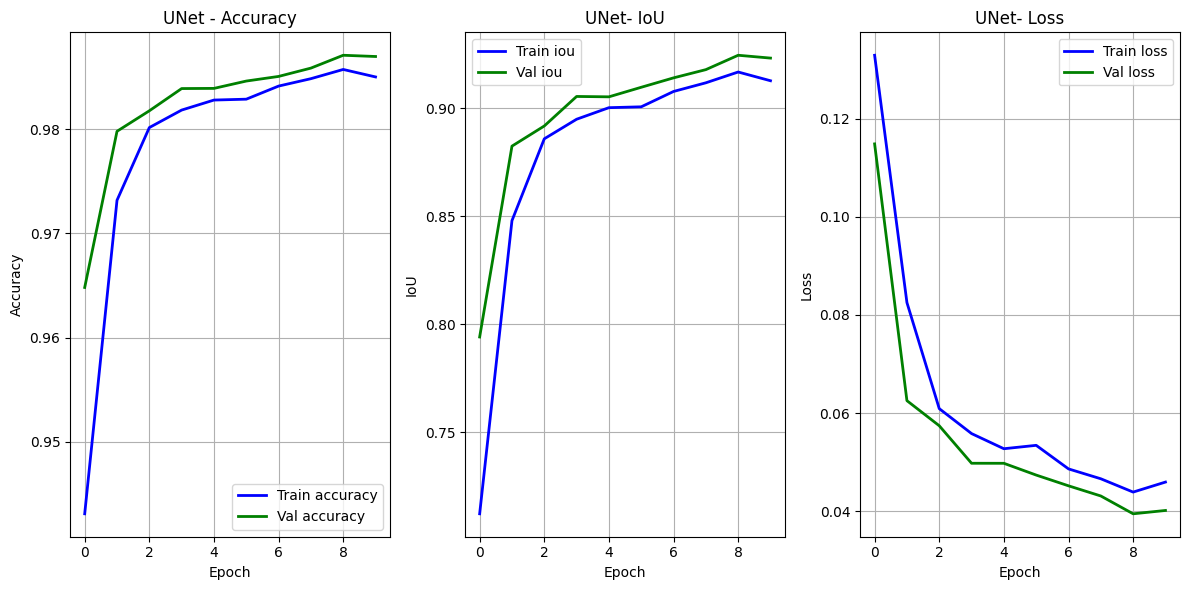

In [20]:
plot_training_history(accuracy_history, iou_history, loss_history, 'UNet')

In [21]:
def visualize_predictions(model, test_dataloader, device, num_samples=4, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(14, 14))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    denorm = lambda x: (x * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)).clamp(0, 1)

    with torch.no_grad():
        for i, (images, masks, _) in enumerate(test_dataloader):
            if i >= num_samples:
                break

            images = images.to(device)
            masks = masks.to(device)

            
            outputs = model(images)
            pred_probs = torch.sigmoid(outputs)  
            pred_masks = (pred_probs > 0.5).float()  

            
            img = images[0].cpu()
            true_mask = masks[0].cpu().squeeze()  
            pred_mask = pred_masks[0].cpu().squeeze()

            
            img_denorm = denorm(img) 

            
            img_np = img_denorm.permute(1, 2, 0).numpy()
            true_mask_np = true_mask.numpy()
            pred_mask_np = pred_mask.numpy()

            
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(true_mask_np, cmap="gray")
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(pred_mask_np, cmap="gray")
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

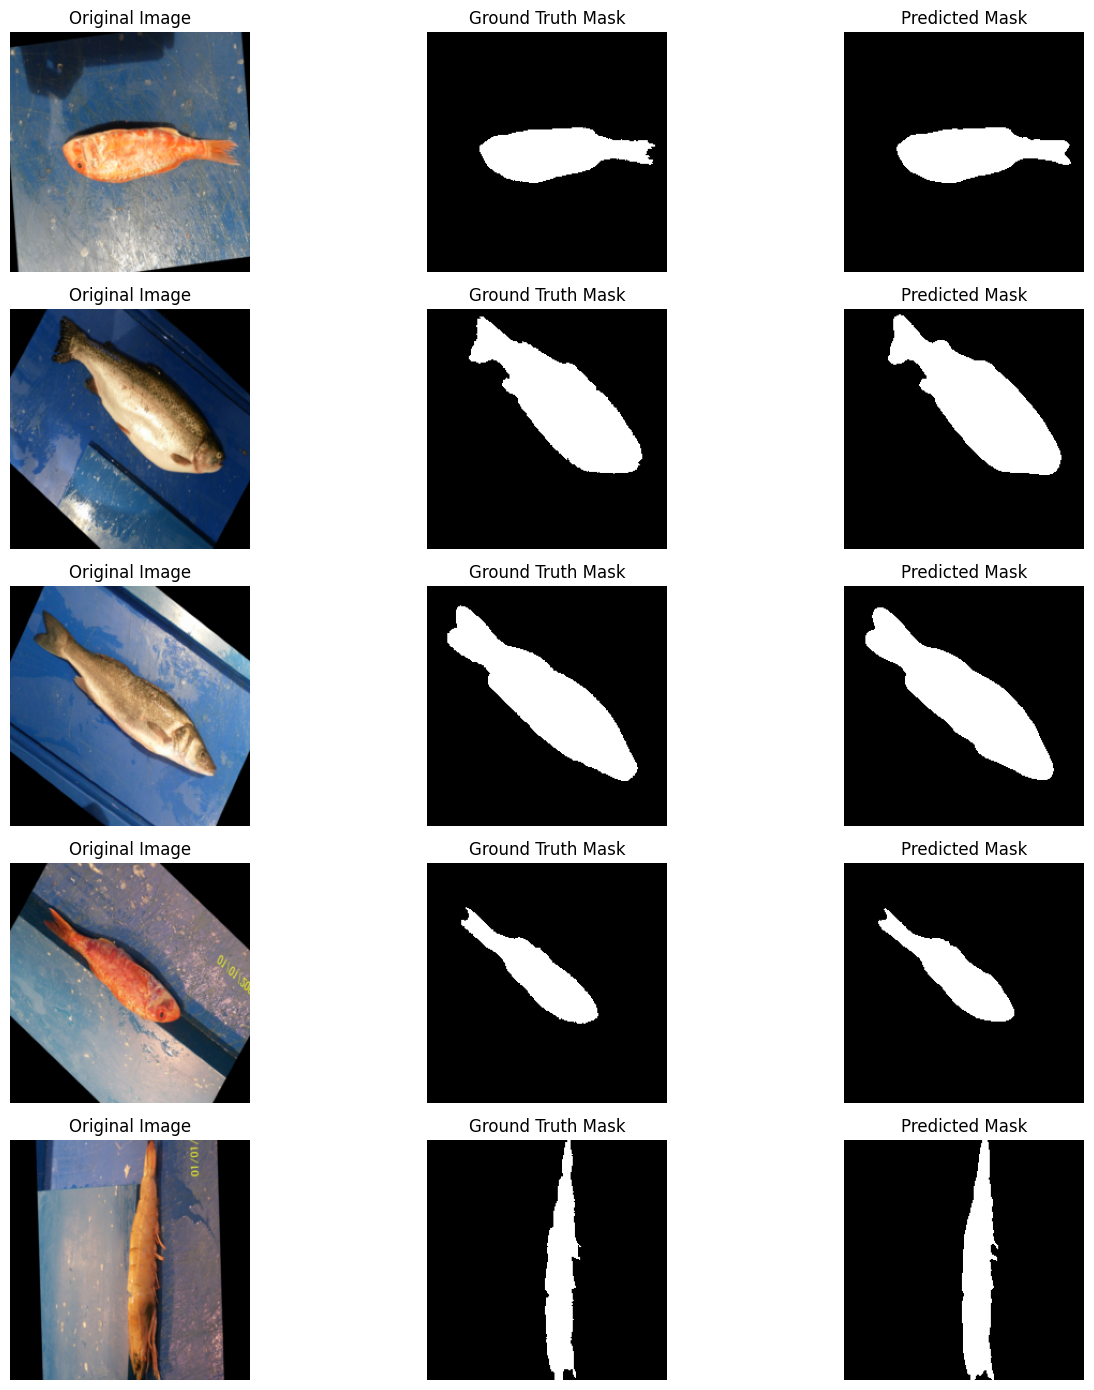

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


visualize_predictions(
    model=model,
    test_dataloader=test_dataloader,
    device=device,
    num_samples=5,
    mean=[0.485, 0.456, 0.406],   
    std=[0.229, 0.224, 0.225]
)